In [37]:
%matplotlib inline
import os
from glob import glob
import re
import pandas as pd
import numpy as np
from pyhocon import ConfigFactory
import pyperclip
from matplotlib import pyplot as plt

In [2]:
input_dir = '../output/conll-2012-transformed'
os.environ['mturk_input_dir'] = input_dir
os.environ['experiment_name'] = ''

In [3]:
suffix = '.m_gold_conll'

In [4]:
def paths2df(paths, experiment_name=None):
    data = [
        {
            'experiment': experiment_name,
            'path': path,
            'genre': re.findall(r'/(\w{2})_', path)[0],
            'transformation': re.findall(r'/([\w-]+)/(?:dev|train|test)', path)[0],
            'base_doc': re.findall(r'/(\w+)\.m.*conll$', path)[0],
        } 
        for path in paths
    ]
    return pd.DataFrame(data)

In [5]:
def copy_conf_string_clipboard(df):
    paths = df['path']
    paths = [re.sub(re.escape(input_dir), '${input_dir}"', p) for p in paths]
    paths = [re.sub(re.escape(suffix), '"${suffix}', p) for p in paths]
    conf_str = '\n'.join('    %s,' %p for p in paths)
    pyperclip.copy(conf_str)

In [66]:
def check_assignments_one_annotator(*dfs):
    ''' 
    Check that the data frames contain each underlying document only once
    or otherwise in an acceptable way. If a document first appear with 
    80% mentions removed and later with 20%, an annotator wouldn't have knowledge
    of anything other than what is shown so it's ok (the generation algorithm make sure
    that the masked mentions in the 20% case are a strict subset of those in 80%).
    '''
    df = pd.concat(dfs)
    def check_group(g):
        if len(g) <= 1:
            return True
        transformations = list(g['transformation'])
        if all(t.startswith('men_') or t == 'orig' for t in transformations):
            percentages = [0 if t == 'orig' else int(t.replace('men_', '')) 
                           for t in transformations]
            return all(p1 > p2 for p1, p2 in zip(percentages, percentages[1:]))
        if all(t.startswith('nonmen_') or t == 'orig' for t in transformations):
            percentages = [0 if t == 'orig' else int(t.replace('nonmen_', '')) 
                           for t in transformations]
            return all(p1 > p2 for p1, p2 in zip(percentages, percentages[1:]))
        return False
    df_check = df.groupby('base_doc').apply(check_group)
    if not all(df_check):
        print('Found problematic assignment:')
        print(df_check[df_check == False])
        assert False
    print('No problem was found')

## All available documents

In [7]:
full_paths = sorted(glob(os.path.join(input_dir, '*', 'dev', '*' + suffix)) +
                    glob(os.path.join(input_dir, '*', 'test', '*' + suffix)))

In [8]:
paths_df = paths2df(full_paths)

In [9]:
paths_df.head(3)

,base_doc,experiment,genre,path,transformation
0,bc_cctv_00_cctv_0000___part_000,None,bc,../output/conll-2012-transformed/men_100/dev/b...,men_100
1,bc_cctv_00_cctv_0000___part_001,None,bc,../output/conll-2012-transformed/men_100/dev/b...,men_100
2,bc_cctv_00_cctv_0000___part_002,None,bc,../output/conll-2012-transformed/men_100/dev/b...,men_100


In [10]:
paths_df.groupby('transformation').agg({'path': 'count'})

,path
transformation,
men_100,687
men_20,688
men_40,687
men_60,687
men_80,687
no-external,688
no-internal,688
no-name,688
nonmen_100,687


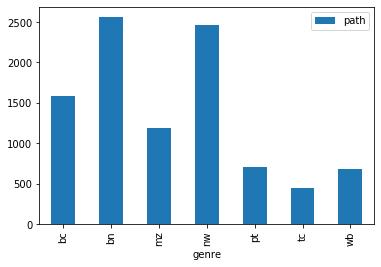

In [36]:
_ = paths_df.groupby('genre').agg({'path': 'count'}).plot.bar()

## CLTL pilot on 23 Jan 2019

In [12]:
conf_cltl_unmasked = ConfigFactory.parse_file('../mturk/configs/cltl-2019-01-23-unmasked.conf')
conf_cltl_masked = ConfigFactory.parse_file('../mturk/configs/cltl-2019-01-23-masked.conf')

In [13]:
cltl_pilot = paths2df(conf_cltl_unmasked.get_list('input_paths') + conf_cltl_masked.get_list('input_paths'))

In [14]:
cltl_pilot.head(3)

,base_doc,experiment,genre,path,transformation
0,bc_msnbc_00_msnbc_0000___part_004,None,bc,../output/conll-2012-transformed/orig/dev/bc_m...,orig
1,bc_cctv_00_cctv_0000___part_011,None,bc,../output/conll-2012-transformed/orig/dev/bc_c...,orig
2,bn_voa_00_voa_0090___part_000,None,bn,../output/conll-2012-transformed/orig/dev/bn_v...,orig


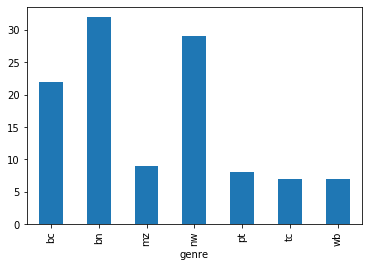

In [15]:
_ = cltl_pilot.groupby('genre')['path'].count().plot.bar()

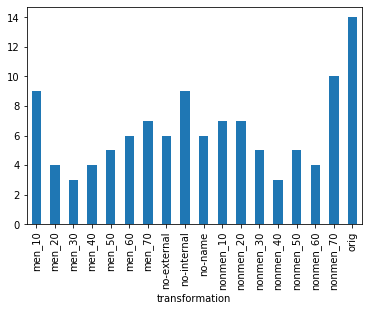

In [16]:
_ = cltl_pilot.groupby('transformation')['path'].count().plot.bar()

In [17]:
len(cltl_pilot.base_doc.unique())

114

In [18]:
cltl_docs = set(cltl_pilot.base_doc.values)

## Student1's documents

Student1 is exposed to CLTL pilot documents (both masked and unmasked) so we need to sample other documents for her. The estimation of 11 min per document (measured during CLTL pilot), she would be able to finish more documents than what's available, so we just picked one version per base document.

In [19]:
student1_conf = ConfigFactory.parse_file('../mturk/configs/student1-2019-03-14.conf')

In [20]:
student1_paths = paths2df(student1_conf.get_list('input_paths'), 'student1')

In [21]:
check_assignments_one_annotator(student1_paths)

In [22]:
print("Number of documents: %d" % len(student1_paths))

Number of documents: 333


In [76]:
def compare_genre_distribution(df):
    fig, axes = plt.subplots(ncols=2, figsize=(8,4))
    df.groupby('genre')['path'].count().plot.bar(ax=axes[0])
    axes[0].title.set_text('Student')
    paths_df.groupby('genre').agg({'path': 'count'}).plot.bar(ax=axes[1])
    axes[1].title.set_text('Reference')

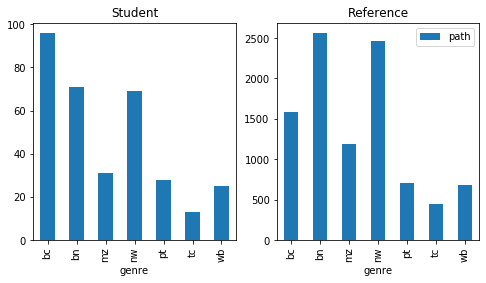

In [77]:
compare_genre_distribution(student1_paths)

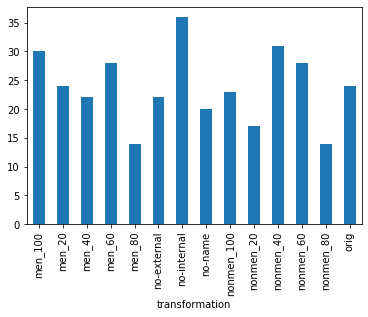

In [78]:
_ = student1_paths.groupby('transformation')['path'].count().plot.bar()

In [79]:
student1_docs = set(student1_paths.base_doc.values)

# Student2's documents

Student 2 will work on some of the same documents as student 1 and can also work on the documents that CLTL members have seen.

In [80]:
student2_practice_conf = ConfigFactory.parse_file('../mturk/configs/student2-practice.conf')

In [81]:
student2_practice_paths = paths2df(student2_practice_conf.get_list('input_paths'))

In [82]:
student2_conf = ConfigFactory.parse_file('../mturk/configs/student2-2019-03-29.conf')

In [83]:
student2_paths = paths2df(student2_conf.get_list('input_paths'), 'student2')

In [84]:
check_assignments_one_annotator(student2_practice_paths, student2_paths)

No problem was found


In [85]:
len(student2_paths)

460

In [86]:
student2_paths.tail(3)

,base_doc,experiment,genre,path,transformation
457,nw_wsj_23_wsj_2369___part_000,student2,nw,../output/conll-2012-transformed/men_20/test/n...,men_20
458,nw_wsj_23_wsj_2370___part_000,student2,nw,../output/conll-2012-transformed/men_80/test/n...,men_80
459,nw_wsj_23_wsj_2371___part_000,student2,nw,../output/conll-2012-transformed/nonmen_100/te...,nonmen_100


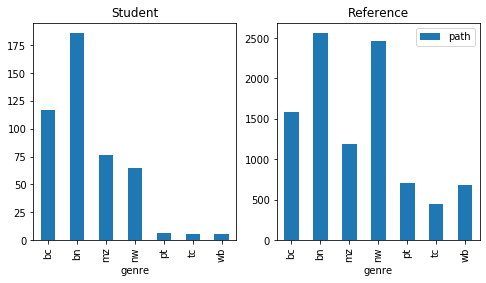

In [87]:
compare_genre_distribution(student2_paths)

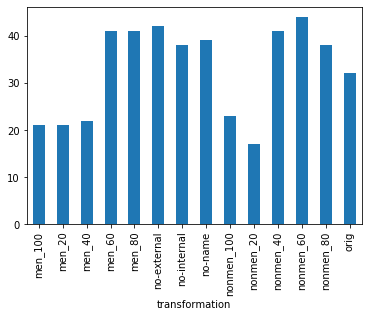

In [88]:
_ = student2_paths.groupby('transformation')['path'].count().plot.bar()

# Student3's documents

This student will work on the same documents that student 1 and 2 have worked on, so that each document is annotated by 2 workers.

In [45]:
student3_conf = ConfigFactory.parse_file('../mturk/configs/student3-2019-03-29.conf')

In [46]:
student3_paths = paths2df(student3_conf.get_list('input_paths'), 'student3')

In [47]:
check_assignments_one_annotator(student3_paths)

In [48]:
len(student3_paths)

319

In [49]:
student3_paths.head(3)

,base_doc,experiment,genre,path,transformation
0,mz_sinorama_10_ectb_1070___part_000,student3,mz,../output/conll-2012-transformed/nonmen_20/dev...,nonmen_20
1,mz_sinorama_10_ectb_1070___part_001,student3,mz,../output/conll-2012-transformed/no-external/d...,no-external
2,mz_sinorama_10_ectb_1070___part_002,student3,mz,../output/conll-2012-transformed/no-internal/d...,no-internal


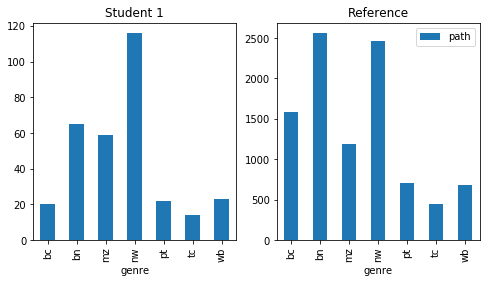

In [50]:
compare_genre_distribution(student3_paths)

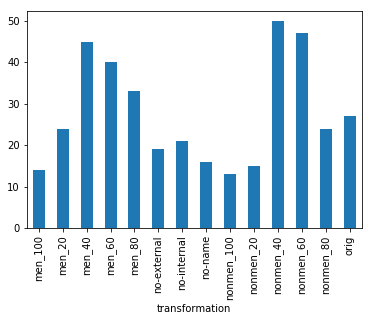

In [296]:
_ = student3_paths.groupby('transformation')['path'].count().plot.bar()

# First author's documents

In [297]:
author1_conf = ConfigFactory.parse_file('../mturk/configs/author1.conf')

In [298]:
author1_paths = paths2df(author1_conf.get_list('input_paths'), 'author1')

In [299]:
check_assignments_one_annotator(author1_paths)

In [300]:
len(author1_paths)

100

In [301]:
author1_paths.head(3)

,base_doc,experiment,genre,path,transformation
0,mz_sinorama_10_ectb_1020___part_001,author1,mz,../output/conll-2012-transformed/nonmen_100/de...,nonmen_100
1,nw_xinhua_02_chtb_0219___part_000,author1,nw,../output/conll-2012-transformed/nonmen_100/te...,nonmen_100
2,tc_ch_00_ch_0020___part_001,author1,tc,../output/conll-2012-transformed/nonmen_80/dev...,nonmen_80


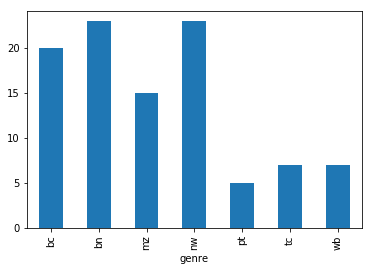

In [302]:
_ = author1_paths.groupby('genre')['path'].count().plot.bar()

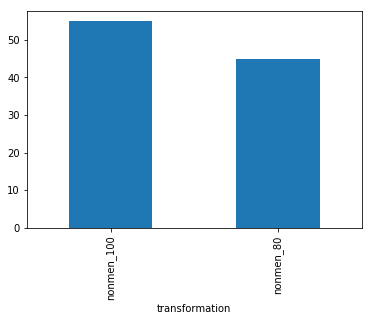

In [303]:
_ = author1_paths.groupby('transformation')['path'].count().plot.bar()

# Overview of all assignments

In [304]:
all_assigments = pd.concat([student1_paths, student2_paths, student3_paths, author1_paths])

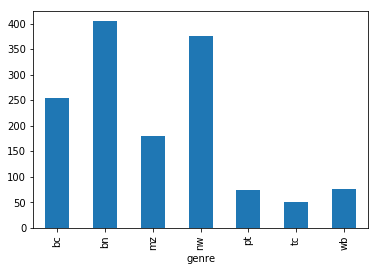

In [305]:
_ = all_assigments.groupby('genre')['path'].count().plot.bar()

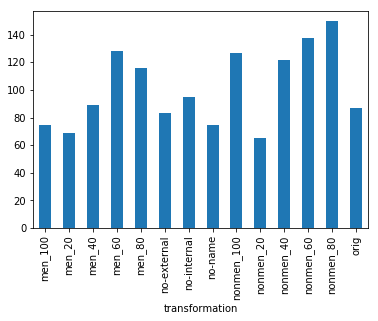

In [306]:
_ = all_assigments.groupby('transformation')['path'].count().plot.bar()

In [307]:
all_assigments.groupby('path').agg({'experiment': 'count'}).describe()

,experiment
count,962.000000
mean,1.475052
std,0.505846
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,3.000000


# back up: saved for next student

In [60]:
assigned_docs = set(student2_paths.base_doc)

In [90]:
candidate_pool = paths_df[~paths_df.base_doc.isin(assigned_docs) &
                          paths_df.transformation.isin(['men_100', 'nonmen_100', 'no-name', 'orig'])]

In [91]:
sampled_paths = candidate_pool.groupby('base_doc').apply(lambda x: x.sample(n=1)).sample(frac=1)
len(sampled_paths)

239

In [71]:
sampled_paths

,,base_doc,experiment,genre,path,transformation
base_doc,,,,,,
wb_c2e_00_c2e_0009___part_000,670,wb_c2e_00_c2e_0009___part_000,None,wb,../output/conll-2012-transformed/men_100/test/...,men_100
mz_sinorama_10_ectb_1020___part_001,5657,mz_sinorama_10_ectb_1020___part_001,None,mz,../output/conll-2012-transformed/nonmen_100/de...,nonmen_100
nw_xinhua_00_chtb_0019___part_000,9525,nw_xinhua_00_chtb_0019___part_000,None,nw,../output/conll-2012-transformed/orig/test/nw_...,orig
nw_xinhua_00_chtb_0049___part_000,594,nw_xinhua_00_chtb_0049___part_000,None,nw,../output/conll-2012-transformed/men_100/test/...,men_100
wb_a2e_00_a2e_0019___part_000,9602,wb_a2e_00_a2e_0019___part_000,None,wb,../output/conll-2012-transformed/orig/test/wb_...,orig
nw_wsj_24_wsj_2452___part_000,9177,nw_wsj_24_wsj_2452___part_000,None,nw,../output/conll-2012-transformed/orig/dev/nw_w...,orig
mz_sinorama_10_ectb_1070___part_003,183,mz_sinorama_10_ectb_1070___part_003,None,mz,../output/conll-2012-transformed/men_100/dev/m...,men_100
nw_xinhua_01_chtb_0160___part_000,9194,nw_xinhua_01_chtb_0160___part_000,None,nw,../output/conll-2012-transformed/orig/dev/nw_x...,orig
nw_wsj_23_wsj_2381___part_000,6078,nw_wsj_23_wsj_2381___part_000,None,nw,../output/conll-2012-transformed/nonmen_100/te...,nonmen_100


In [72]:
sampled_paths.head(3)

,,base_doc,experiment,genre,path,transformation
base_doc,,,,,,
wb_c2e_00_c2e_0009___part_000,670,wb_c2e_00_c2e_0009___part_000,None,wb,../output/conll-2012-transformed/men_100/test/...,men_100
mz_sinorama_10_ectb_1020___part_001,5657,mz_sinorama_10_ectb_1020___part_001,None,mz,../output/conll-2012-transformed/nonmen_100/de...,nonmen_100
nw_xinhua_00_chtb_0019___part_000,9525,nw_xinhua_00_chtb_0019___part_000,None,nw,../output/conll-2012-transformed/orig/test/nw_...,orig


In [73]:
check_assignments_one_annotator(student2_paths, sampled_paths)

No problem was found


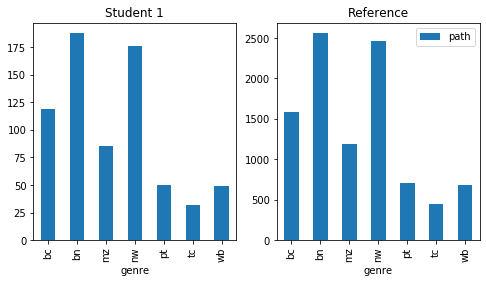

In [74]:
compare_genre_distribution(pd.concat([student2_paths, sampled_paths]))

In [89]:
copy_conf_string_clipboard(sampled_paths)